In [ ]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.ensemble import VotingClassifier
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans


# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt')

from google.colab import drive
drive.mount("GoogleDrive")

# Load data and Change this path Accordingly
data = pd.read_csv("GoogleDrive/MyDrive/SocialMediaTrendAnalysisDatasets/BollywoodTweets/tweets1m.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at GoogleDrive


In [ ]:
from nltk.tokenize import word_tokenize
import string

def preprocess_text(text):
    # Tokenize the text using NLTK's word_tokenize function
    tokens = word_tokenize(text)

    # Defining a set of stopwords in English using NLTK's stopwords module
    stop_words = set(stopwords.words('english'))

    #Create a set of punctuation characters using Python's string module
    punctuation = set(string.punctuation)

    # A stemmer using NLTK's PorterStemmer
    stemmer = PorterStemmer()

    # Performing preprocessing steps
    #Convert words to lowercase, remove stopwords, and filter out non-alphabetic words
    tokens = [word.lower() for word in tokens if
              word.isalpha() and word.lower() not in stop_words and word not in punctuation]
    #Apply stemming to the remaining words to reduce them to their root form
    tokens = [stemmer.stem(word) for word in tokens]

    # Join the preprocessed tokens back into a single string
    return ' '.join(tokens)

# Create a binary label column indicating whether a tweet contains '#BoycottBollywood'
data["Label"] = data["Tweet"].str.contains("#BoycottBollywood", case=False, regex=True).astype(int)
#data["Label"] = data["Tweet"].str.contains("GemsOfBollywood", case=False, regex=True).astype(int)

# Clean tweets
data["Tweet"] = data["Tweet"].apply(preprocess_text)

In [ ]:
print(data.columns)

Index(['Unnamed: 0', 'Date', 'User', 'Tweet', 'Label'], dtype='object')


In [ ]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Extract TF-IDF features
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(train_data["Tweet"])
X_val = vectorizer.transform(val_data["Tweet"])
X_test = vectorizer.transform(test_data["Tweet"])

# Targets
y_train = train_data["Label"]
y_val = val_data["Label"]
y_test = test_data["Label"]

# Train Logistic Regression model
model_lr = LogisticRegression(solver="liblinear")
model_lr.fit(X_train, y_train)

# Predict on the validation set
y_pred_lr = model_lr.predict(X_val)

# Calculate accuracy for Logistic Regression
accuracy_lr = accuracy_score(y_val, y_pred_lr)
precision_lr = precision_score(y_val, y_pred_lr)
recall_lr = recall_score(y_val, y_pred_lr)
f1_lr = f1_score(y_val, y_pred_lr)
confusion_matrix_lr= confusion_matrix(y_val, y_pred_lr)
print("\n Logistic Regression Accuracy:", accuracy_lr)
print("\n Logistic Regression Precision:", precision_lr)
print("\n Logistic Regression Recall:", recall_lr)
print("\n Logistic Regression F1 Score:", f1_lr)
print("\n Logistic Regression Confusion Matrix:",confusion_matrix_lr)


 Logistic Regression Accuracy: 0.9954648983129422

 Logistic Regression Precision: 0.9955600403632694

 Logistic Regression Recall: 0.9998986520725651

 Logistic Regression F1 Score: 0.9977246296202659

 Logistic Regression Confusion Matrix: [[   58   220]
 [    5 49330]]


In [ ]:
# Wrap Logistic Regression model for compatibility with VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
class LogRegWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.model.predict_proba(X)

# Wrap Logistic Regression model
model_lr_wrapper = LogRegWrapper(model_lr)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.sparse import coo_matrix
from tensorflow.sparse import SparseTensor, reorder

# Train Word2Vec model
model_w2v = Word2Vec(sentences=data["Tweet"].tolist(), min_count=1, window=3, vector_size=100)

# Generate word vectors for each tweet
def tweet_to_vec(tweet):
    words = tweet.split()
    vec = np.zeros(100)
    for word in words:
        try:
            vec += model_w2v.wv[word]
        except KeyError:
            pass

    return vec

data["Tweet_vec"] = data["Tweet"].apply(tweet_to_vec)


# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(data["Tweet"])
sequences = tokenizer.texts_to_sequences(data["Tweet"])
padded_sequences = pad_sequences(sequences, maxlen=100)

# Create a wrapper for Keras model to make it compatible with VotingClassifier
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=1, validation_split=0.2)
        return self
    # def fit(self, X, y):
    #     self.model.fit(X, y)
    #     return self

    def predict_proba(self, X):
        return self.model.predict(X)

# Train LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(1000, 128, input_length=100))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary cross-entropy loss
model_lstm.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Train LSTM model
model_lstm.fit(padded_sequences, data["Label"], epochs=3, validation_split=0.2)

# Create a wrapper for LSTM model
model_lstm_wrapper = KerasClassifierWrapper(model_lstm)

# Evaluate LSTM model
y_pred_lstm = (model_lstm.predict(padded_sequences) > 0.5).astype(int)
accuracy_lstm = accuracy_score(data["Label"], y_pred_lstm)
precision_lstm = precision_score(data["Label"], y_pred_lstm)
recall_lstm = recall_score(data["Label"], y_pred_lstm)
f1_lstm = f1_score(data["Label"], y_pred_lstm)
confusion_matrix_lstm = confusion_matrix(data["Label"], y_pred_lstm)
print("LSTM Accuracy:", accuracy_lstm)
print("LSTM Precision:", precision_lstm)
print("LSTM Recall:", recall_lstm)
print("LSTM F1 Score:", f1_lstm)
print("LSTM Confusion Matrix:",confusion_matrix_lstm)


Epoch 1/3
7752/7752 [==============================] - 93s 11ms/step - loss: 0.0240 - accuracy: 0.9960 - val_loss: 0.0395 - val_accuracy: 0.9938
Epoch 2/3
7752/7752 [==============================] - 74s 10ms/step - loss: 0.0190 - accuracy: 0.9967 - val_loss: 0.0420 - val_accuracy: 0.9936
Epoch 3/3
9690/9690 [==============================] - 35s 4ms/step
LSTM Accuracy: 0.9963493174320093
LSTM Precision: 0.9964195580028372
LSTM Recall: 0.9999221726793677
LSTM F1 Score: 0.9981677926433314
LSTM Confusion Matrix: [[   596   1108]
 [    24 308351]]


In [ ]:
from sklearn.utils.validation import check_is_fitted
from scipy.sparse import csr_matrix
from tensorflow.sparse import from_dense
import tensorflow as tf


# Ensure sparse matrix indices are sorted
sorted_indices = np.argsort(X_train.indices)
X_train_sorted = csr_matrix((X_train.data[sorted_indices], X_train.indices[sorted_indices], X_train.indptr), shape=X_train.shape)

# Convert the sorted sparse matrix to a dense array
X_train_dense = X_train_sorted.toarray()
X_train_dense_truncated = X_train_dense[:, :100]

ensemble_model = VotingClassifier(estimators=[("lr", model_lr_wrapper), ("lstm", model_lstm_wrapper)], voting="soft")
ensemble_model.fit(X_train_dense_truncated, y_train)


X_val_transformed = vectorizer.transform(val_data["Tweet"])
sorted_indices_val = np.argsort(X_val_transformed.indices)
X_val_sorted = csr_matrix((X_val_transformed.data[sorted_indices_val], X_val_transformed.indices[sorted_indices_val], X_val_transformed.indptr), shape=X_val_transformed.shape)

X_val_dense = X_val_sorted.toarray()
X_val_dense_truncated = X_val_dense[:, :100]

probs_list = []
for clf in ensemble_model.estimators_:
    proba = clf.predict_proba(X_val_dense_truncated)

    # Check the number of columns in the probability array
    if proba.shape[1] == 1:
        # For binary classification, use the probability for the positive class
        probs_list.append(proba[:, 0])
    else:
        # For multi-class classification or binary classification with explicit columns, use column 1
        probs_list.append(proba[:, 1])

# Average the probabilities
y_pred_probs_ensemble = np.mean(probs_list, axis=0)

# Convert probabilities to binary predictions
y_pred_ensemble = (y_pred_probs_ensemble > 0.5).astype(int)
accuracy_ensemble = accuracy_score(y_val, y_pred_ensemble)
precision_ensemble = precision_score(y_val, y_pred_ensemble)
recall_ensemble = recall_score(y_val, y_pred_ensemble)
f1_ensemble = f1_score(y_val, y_pred_ensemble)
confusion_matrix_ensemble = confusion_matrix(y_val, y_pred_ensemble)

print("Ensemble Model Accuracy:", accuracy_ensemble)
print("Ensemble Model Precision:", precision_ensemble)
print("Ensemble Model Recall:", recall_ensemble)
print("Ensemble Model F1 Score:", f1_ensemble)
print("Ensemble Model Confusion Matrix:", confusion_matrix_ensemble)



1551/1551 [==============================] - 6s 3ms/step
Ensemble Model Accuracy: 0.9943966299155463
Ensemble Model Precision: 0.9943966299155463
Ensemble Model Recall: 1.0
Ensemble Model F1 Score: 0.9971904434652544
Ensemble Model Confusion Matrix: [[    0   278]
 [    0 49335]]


In [ ]:
# Dealing with Data Imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_dense_truncated, y_train)

# Retrain Logistic Regression model with resampled data
model_lr_resampled = LogisticRegression(solver="liblinear")
model_lr_resampled.fit(X_train_resampled, y_train_resampled)

# Evaluate the Logistic Regression model on the validation set
y_pred_lr_resampled = model_lr_resampled.predict(X_val_dense_truncated)
accuracy_lr_resampled = accuracy_score(y_val, y_pred_lr_resampled)
precision_lr_resampled = precision_score(y_val, y_pred_lr_resampled)
recall_lr_resampled = recall_score(y_val, y_pred_lr_resampled)
f1_lr_resampled = f1_score(y_val, y_pred_lr_resampled)
confusion_matrix_lr_resampled = confusion_matrix(y_val, y_pred_lr_resampled)

print("\n Logistic Regression (Resampled) Accuracy:", accuracy_lr_resampled)
print("\n Logistic Regression (Resampled) Precision:", precision_lr_resampled)
print("\n Logistic Regression (Resampled) Recall:", recall_lr_resampled)
print("\n Logistic Regression (Resampled) F1 Score:", f1_lr_resampled)
print("\n Logistic Regression (Resampled) Confusion Matrix:", confusion_matrix_lr_resampled)


 Logistic Regression (Resampled) Accuracy: 0.03349928446173382

 Logistic Regression (Resampled) Precision: 0.01276955080015653

 Logistic Regression (Resampled) Recall: 0.9717868338557993

 Logistic Regression (Resampled) F1 Score: 0.025207863227013075

 Logistic Regression (Resampled) Confusion Matrix: [[ 1042 47933]
 [   18   620]]


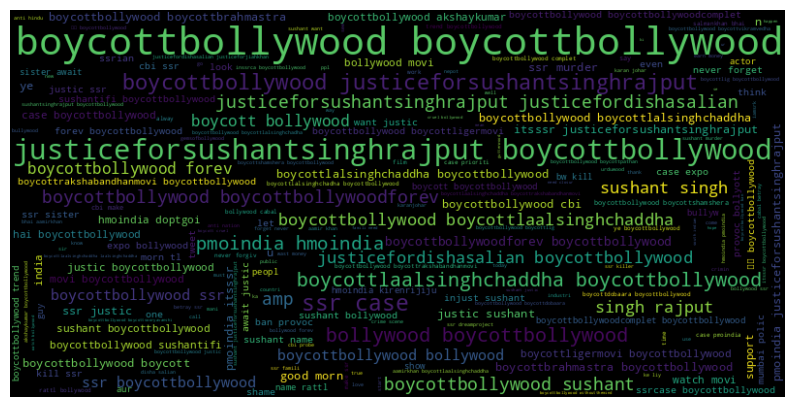

In [ ]:
# Word Cloud Visualization
all_tweets = " ".join(data["Tweet"])
wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=110).generate(all_tweets)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [ ]:
count = 0
top_ten = {}
for k,v in wordcloud.words_.items():
    count += 1
    if count < 10 and k not in  top_ten:
        top_ten.update({k:v})
top_ten

{'boycottbollywood boycottbollywood': 1.0,
 'justiceforsushantsinghrajput boycottbollywood': 0.8900662251655629,
 'ssr case': 0.51777890983189,
 'boycottbollywood justiceforsushantsinghrajput': 0.48512480896586857,
 'bollywood boycottbollywood': 0.3936321956189506,
 'boycottlaalsinghchaddha boycottbollywood': 0.3916963830871116,
 'pmoindia hmoindia': 0.371268466632705,
 'justiceforsushantsinghrajput justicefordishasalian': 0.35165562913907283,
 'amp': 0.34885379521141113}

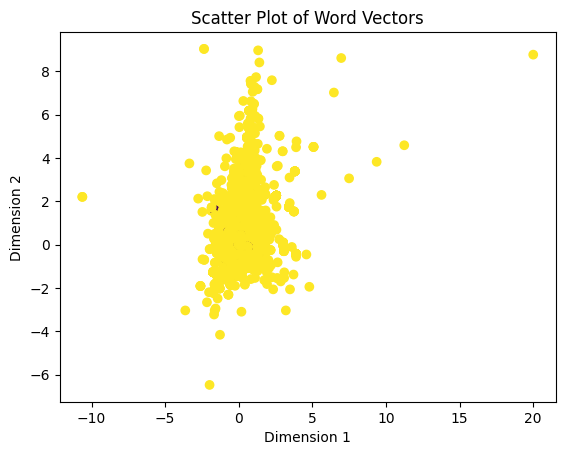

In [ ]:
# Scatter Plot (Example: Using word vectors from Word2Vec)
plt.scatter(data["Tweet_vec"].apply(lambda x: x[0]), data["Tweet_vec"].apply(lambda x: x[1]), c=data["Label"], cmap='viridis')
plt.title('Scatter Plot of Word Vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

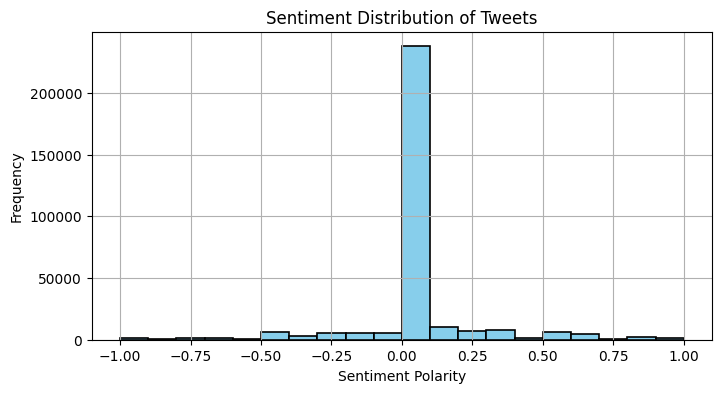

In [ ]:
from textblob import TextBlob

# Add sentiment analysis to the DataFrame
data['Sentiment'] = data['Tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.figure(figsize=(8, 4))
data['Sentiment'].hist(bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Sentiment Distribution of Tweets')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

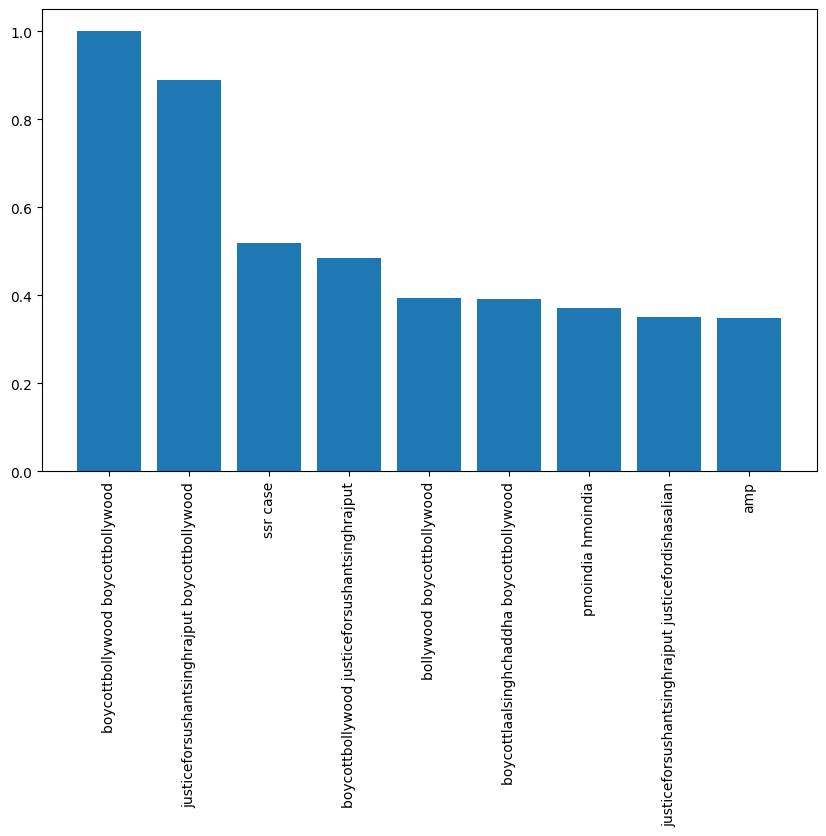

In [ ]:
names = list(top_ten.keys())
values = list(top_ten.values())
plt.figure(figsize=(10,6))
plt.bar(range(len(top_ten)),values,tick_label=names,)
plt.xticks(rotation=90)
plt.show()